Now, we're going to look at the more general reaction diffustion equation given in Garazayan et. al and make a few assumption to reduce it to a Fischer-KPP equation to analyse it in terms of the Hoffman et. al. analysis. Starting with 

$$
u_t = d_1\nabla_G^2u + \frac{\gamma}{1+e^{-\beta(v-\alpha)}}u(1-u) - \omega u\\
v_t = d_2\nabla_G^2 + 1 - \theta(1+u)^pv
$$

And let $\theta=\alpha=0$ and $p=0$. This reduces our system to a decoupled system where $v$ has a fixed equillibrium point independent of $u$.

$$
u_t = d_1\nabla_G^2u + \frac{\gamma}{1+e^{-\beta(v-1)}}u(1-u) - \omega u\\
v_t = d_2\nabla_G^2 + 1 - v
$$

Letting $v$ equillibrate to $v^* = 1$ gives simply the Fisher-KPP equation.

$$
u_t = d_1\nabla_G^2u + \frac{\gamma}{2}u(1-u) - \omega u = d_1\nabla_G^2u +\Gamma u ((\frac{1}{2}-\frac{\omega}{\Gamma})-u)\\
$$

I will simply let $K = \Gamma$ and $C = \frac{1}{2}-\frac{\omega}{\Gamma}$ so

$$
u_t = d_1\nabla_G^2u +Ku (C-u)\\
$$

And interpret $C$ as a carrying capacity and $K$ as a growth rate.

Now, we can examine the dynamics on a homogenous infinite tree as in Hoffman. Letting $u_{(j)}$ denote an arbitrary node from level $j$ in the tree and assert that each node has $k+1$ connections, and let the reaction term be deonted $g(u)$ our equations are written as 

$$
u_{(1)}(0) = C\\
u_{(1)t} = d_1(k+1)(-u_{(1)}+u_{(2)}) + g(u_{(1)})\\
u_{(j)t} = d_1(u_{(j-1)}-(k+1)u_{(j)}+ku_{(j+1)}) = g(u_{(j)}) , \, j >1
$$

Now, we linearize about u_{(j)} = 0, since Fisher KPP is linear determinant, and seek solutions in the form a exponential temporal growth and spatial decay, $e^{\lambda t-\gamma j}$. This provides a dispersion relation. We assume this in the bulk of the tree, so substituting the equation gives

$$
d(\lambda, \gamma) = d_1\left(e^\gamma - (k+1) + ke^{-\gamma}\right) + KC - \lambda
$$

Now, we seek a moving frame, as the linear spreading speed, in order to determine the solution transitions from an absolute to an advective instability, i.e. double root criterion, this provides a pair of equations whose roots determine the spreading speed and the spatial decay term, $\gamma$. Letting $d_s(\lambda, \gamma) = d(\lambda + st, \gamma)$, finding a root and enforcing that it is indeed a double root provides

$$
F(s, \gamma, d_1, KC)
=
\begin{bmatrix}
d_s(0, \gamma) = d_1\left(e^\gamma - (k+1) + ke^{-\gamma}\right) + KC - s\gamma \\
\partial_{\gamma}d_s(0, \gamma) = d_1\left(e^\gamma -ke^{-\gamma}\right) - s\\
\end{bmatrix}
$$

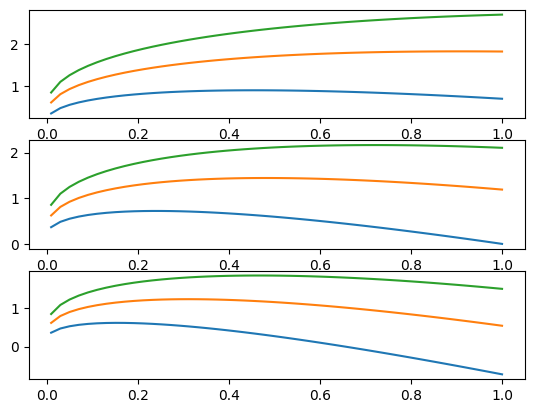

In [2]:
from scipy.optimize import root
import numpy as np
from matplotlib import pyplot as plt

def get_speed_curve(k, KC):
    def speed_curve(alpha):
        def f(x):
            g, s = x[0], x[1]
            return np.array([alpha*(np.exp(g)-k-1+k*np.exp(-g))-s*g+KC, alpha*(np.exp(g)-k*np.exp(-g))-s])
        sol = root(f, np.array([1, 1]))
        return sol.x[1]
    
    return speed_curve
  
KCs = [1, 2, 3]
ks = [3, 4, 5]
ds = np.linspace(0.01, 1, 50)

fig, axes = plt.subplots(3)
for k in ks:
    for KC in KCs:
        speed_curve = get_speed_curve(k, KC)
        buff = np.zeros(len(ds))
        for ii in range(len(ds)):
            buff[ii] = speed_curve(ds[ii])
        axes[k-3].plot(ds, buff)


One thing to note, right off the bat, is that increasing the $KC$ constant seems to increase the linear spreading speed, regardless of $d_1$ or the degree $k+1$. There may be a comparison principle that can be used here. Recall that $KC = \frac{\Gamma}{2} - \omega$. Following Hoffman, we can show that our critical points, $\alpha_1, \, \alpha_2$ are simply scaled by the factor of $KC$, with $\gamma_1 = \log(k), \, \gamma_2 = \frac{1}{2}\log(k)$ as before.

A quick note of caution, when evaluating these curves, there seems to be some sensitivity of the rootfinding algorithm to starting guess. For the curves above, I had to find conditions ad hoc to make these work out. Elsewise, there is some strange behavior. Long story short, I don't have a way to generate a reasonable starting guess that will show convergence at the moment.

We can then run a brief simulation to show this using the modifed reaction diffusion equations provided.

<IPython.core.display.Javascript object>


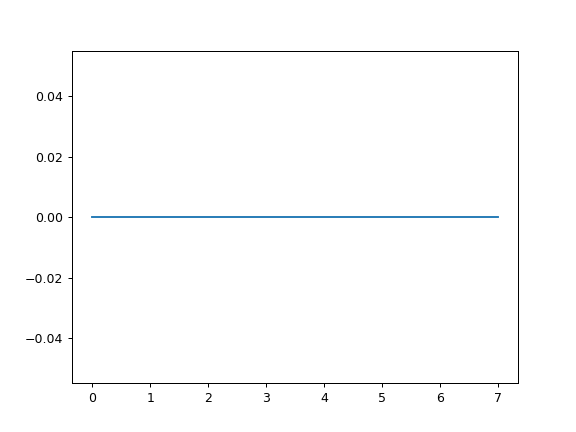

In [5]:
from scipy.optimize import root
import numpy as np
from matplotlib import pyplot as plt
from DynaNet import visualize
%matplotlib notebook
from matplotlib import animation
import matplotlib.colors as colors
import networkx as nx
import DynaNet
from Equations import FisherKPPExtendedStep as KPP

# Set exponent of graph size
N = 8

# Note here that 0 is our Root node and will follow special dynamics
G = nx.full_rary_tree(3, (3**N-1)//2)
H = nx.full_rary_tree(3, (3**(N-1)-1)//2)
mapping = {i:(i+len(G.nodes)) for i in range(len(H.nodes))}
R = nx.compose(G, nx.relabel_nodes(H, mapping))
R.add_edge(0, len(G.nodes))
G = R

# Get the relevant Adjacency Matrix
adj = nx.to_numpy_array(G)

# Make our dynamic network
DN = DynaNet.DynaNet(adj_mtx=adj)

# DE parameters
alpha = 0.25
ks = np.array([-alpha for ii in DN.vert])
vs = np.array([0 for ii in DN.vert])
rates = np.array([2 for _ in DN.vert])
capacities = np.array([-1 for _ in DN.vert])

# Initial parameters
f0 = np.zeros(len(DN.vert))
f0[0] = 1
t0 = 0
tf = 20
nt = 1000
t = np.linspace(t0, tf, nt)

# Let'r rip
DN.solve_ivp(KPP, f0, t0, tf, nt, ks, vs, rates, capacities)
res = DN.solve_ivp_results

# Set a thresholding value. This is largely arbitrary, so I will use 0.2
thresh = 0.2

# transform results to their thresholded values
thresh_res = res.y > thresh

# find geodesic distances from root node, 0
spl = nx.shortest_path_length(G, source=list(G.nodes)[0])

# get node distances
node_order = list(G.nodes)
node_dists = {ii: spl[node_order[ii]] for ii in range(len(thresh_res[:, 0]))}

# get mean arrival times
un = np.unique(list(spl.values()))
n_l = {ii:len([jj for jj in node_dists.keys() if node_dists[jj]==ii]) for ii in un}
arrival_times = np.argmax(thresh_res, axis=1)*(tf/nt)
t_l = {ii:sum(arrival_times[jj] for jj, kk in node_dists.items() if kk==ii)/n_l[ii] for ii in un}

plt.plot(t_l.keys(), t_l.values())

In [3]:
1/np.polyfit(list(t_l.keys())[5:], list(t_l.values())[5:], 1)[0]

1.7857142857148034

We get a resonable agreement with the theoretical value. The numerical disagreement is likely due to finite size effects (we are only using 8 layers, but the analysis is for an infinite graph), and lack of settling into a wave form (recall that a true spreading speed cares about $t, n \, \rightarrow \infty$)

We can do a quick survey for, say, $k=3, KC=2, \alpha \in [0, 1]$

In [4]:
# Set exponent of graph size
N = 6

# Note here that 0 is our Root node and will follow special dynamics
G = nx.full_rary_tree(3, (3**N-1)//2)
H = nx.full_rary_tree(3, (3**(N-1)-1)//2)
mapping = {i:(i+len(G.nodes)) for i in range(len(H.nodes))}
R = nx.compose(G, nx.relabel_nodes(H, mapping))
R.add_edge(0, len(G.nodes))
G = R

# Get the relevant Adjacency Matrix
adj = nx.to_numpy_array(G)

# Make our dynamic network
DN = DynaNet.DynaNet(adj_mtx=adj)

diffs = np.linspace(0.01, 1, 20)
numeric_speeds = []

for diff in diffs:

    # DE parameters
    alpha = diff
    ks = np.array([-alpha for ii in DN.vert])
    vs = np.array([0 for ii in DN.vert])
    rates = np.array([2 for _ in DN.vert])
    capacities = np.array([1 for _ in DN.vert])

    # Initial parameters
    f0 = np.zeros(len(DN.vert))
    f0[0] = 1
    t0 = 0
    tf = 20
    nt = 1000
    t = np.linspace(t0, tf, nt)

    # Let'r rip
    DN.solve_ivp(KPP, f0, t0, tf, nt, ks, vs, rates, capacities)
    res = DN.solve_ivp_results

    # Set a thresholding value. This is largely arbitrary, so I will use 0.2
    thresh = 0.2

    # transform results to their thresholded values
    thresh_res = res.y > thresh

    # find geodesic distances from root node, 0
    spl = nx.shortest_path_length(G, source=list(G.nodes)[0])

    # get node distances
    node_order = list(G.nodes)
    node_dists = {ii: spl[node_order[ii]] for ii in range(len(thresh_res[:, 0]))}

    # get mean arrival times
    un = np.unique(list(spl.values()))
    n_l = {ii:len([jj for jj in node_dists.keys() if node_dists[jj]==ii]) for ii in un}
    arrival_times = np.argmax(thresh_res, axis=1)*(tf/nt)
    t_l = {ii:sum(arrival_times[jj] for jj, kk in node_dists.items() if kk==ii)/n_l[ii] for ii in un}

    speed = 1/np.polyfit(list(t_l.keys())[2:], list(t_l.values())[2:], 1)[0]
    numeric_speeds.append(speed)
    
plt.plot(diffs, numeric_speeds)
speed_curve = get_speed_curve(3, 2)
plt.plot(diffs, [speed_curve(ii) for ii in diffs])

Here we see that for diffusion coefficients less than about $0.4$, our finite tree approximation is quite good, then as the diffusion coefficient becomes larger, the finite size effects begin to dominate the linear spreading speed approximation, so this particular simulation is not particularly acurate for estimating our $\alpha_1$ and $\alpha_2$ critical points. 

# Critical Coefficients

To talk about the critical coefficients, $\alpha_1, \, \alpha_2$, where our linear spreading speed is at a maximum and zero respectively. Consider again our function whose roots are a locus for pinched double roots

$$
F(s, \gamma, d_1, KC)
=
\begin{bmatrix}
d_s(0, \gamma) = d_1\left(e^\gamma - (k+1) + ke^{-\gamma}\right) + KC - s\gamma \\
\partial_{\gamma}d_s(0, \gamma) = d_1\left(e^\gamma -ke^{-\gamma}\right) - s\\
\end{bmatrix}
$$

Following the analysis in the Hoffman, we note that setting $s=0$ in the second component gives $\gamma_2 = \frac{1}{2} \log(k)$, and substitution into the first component gives $d_{1, 2} = \frac{KC}{k+1-2\sqrt{k}}$, which is just the original diffusion coefficient scaled by $KC$. 

Similarly for other critical point, where we let $\gamma_1 = \log(k)$, which is the point where our solution is $l_1$ normalizable, we solve our equation with $s_1 = \frac{KC}{\log(k)}, \, d_{1, 1} = \frac{KC}{\log(k)(k+1)}$, which are, again, just scaled versions of the case where $KC = 1$

Further, we can show invertability via implicit function theorem, so 

$$
F_{s, \gamma}(s, \gamma, d_1, KC)
=
\begin{bmatrix}
-\gamma & d_1\left(e^\gamma - ke^{-\gamma}\right) - s \\
-1 & d_1\left(e^\gamma + ke^{-\gamma}\right)\\
\end{bmatrix}, \, 
F_{d_1, KC}(s, \gamma, d_1, KC)
=
\begin{bmatrix}
e^\gamma - (k+1) + ke^{-\gamma} & 1 \\
e^\gamma -ke^{-\gamma} & 0\\
\end{bmatrix}
$$

Since $F_{s, \gamma}(s_1, \gamma_1, d_1, KC)$ is invertible, at the $l_1$ critical point, we have a valid $s(d_1, KC)$ and $\gamma(d_1, KC)$ about that point, so our linear spreading speed and spatial decay are well defined.

For the time being, I will skip over the asymptotic analysis in the limit of small $\alpha$, as well as the results on the periodic homogenous tree, namely because such a graph will be challenging to construct in code at the moment.

# Aggregate Dynamics

Consider the total population growth, also called the $l_1$ norm of our solution. Note first that the number of representative nodes at each level follow the following 

\begin{align}
n=1,& \, 1\\
n=2,& \, k+1\\
n=3,& \, (k+1)k\\
&\vdots\\
n=n,& \, k^{n-2}(k+1)
\end{align}

Then our population growth will be our weighted sum

$$
P(t) = \sum_{n=1}^{\infty}k^{n-2}(k+1)u_{(n)}(t)
$$

Then letting $w_{(n)}(t) = k^{n-2}(k+1)u_{(n)}(t)$, then $P(t) = \sum_{n=1}^{\infty}w_{(n)}(t)$, our equations become

$$
\dot{w}_{(1)}(t) = d_1(k(0-w_{(1)}) + (w_{(2)}-w_{(1)})) + Kw_{(1)}[C-k^{2-n}(k+1)^{-1}w_{(1)}]\\
\dot{w}_{(n)}(t) = d_1(k(w_{(n-1)}-w_{(n)}) + (w_{(n+1)}-w_{(n)})) + Kw_{(n)}[C-k^{2-n}(k+1)^{-1}w_{(n)}]\\
$$

We can note that by the same proceedure, we can derive the dispersion relation
$$
\bar{d}(\lambda, \gamma) = d_1(ke^{\gamma}-(k+1)+e^{-\gamma})+KC-\lambda \\
$$

The calculations for the new dispersion relation is identical. Letting $\gamma^*, \, \lambda^*$ be pinched double roots of the non-exponentially weighted dispersion yield new roots for the weighted one as

$$
\bar{\lambda^*} = \lambda^* + s \log(k)\\
\bar{\gamma^*} = \gamma - \log(k)
$$